# More NEXRAD Level II Visualization
---

## Overview
   
Within this notebook, we will cover:

1. Adding range rings to a PPI plot
1. Calculate and display a Velocity Azimuthal Display (VAD) profile

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Cartopy Intro](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Required | Projections and Features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |

- **Time to learn**: 20 minutes
---

## Imports

In [1]:
import pyart
import fsspec
from metpy.plots import USCOUNTIES, ctables
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from datetime import datetime as dt
from datetime import timedelta
import numpy as np

import matplotlib

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


## Select the time and NEXRAD site

In [29]:
datTime = dt(2013,5,20,20)
year = dt.strftime(datTime,format="%Y")
month = dt.strftime(datTime,format="%m")
day = dt.strftime(datTime,format="%d")
hour = dt.strftime(datTime,format="%H")
timeStr = f'{year}{month}{day}{hour}'

site = 'KTLX'

Point to the [AWS S3 filesystem](https://aws.amazon.com/s3/)

In [30]:
fs = fsspec.filesystem("s3", anon=True)

Depending on the year, the radar files will have different naming conventions. 

In [31]:
pattern1 = f's3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*V06'
pattern2 = f's3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*V*.gz'
pattern3 = f's3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*.gz'

Construct the URL pointing to the radar file directory and get a list of matching files.

Try each file pattern. Once the list of files is non-empty, we are all set.

In [32]:
files = sorted(fs.glob(pattern1))

if (len(files) == 0):
    files = sorted(fs.glob(pattern2))  

if (len(files) == 0):
    files = sorted(fs.glob(pattern3))   

If we still have an empty list, either there are no files available for that site/date, or the file name does not match any of the patterns above. 

In [33]:
if (len(files) == 0):
    print ("There are no files found for this date and location. Either try a different date/site, \
or browse the NEXRAD2 archive to see if the file name uses a different pattern.")
else:
    print (files)

['noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_200356_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_200811_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_201229_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_201643_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_202058_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_202511_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_202928_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_203346_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_203800_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_204215_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_204630_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_205045_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_205459_V06.gz', 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_205914_V06.gz']


## Read the Data into PyART

Read in the first radar file in the group and list the available fields.

In [34]:
radar = pyart.io.read_nexrad_archive(f's3://{files[0]}')
list(radar.fields)

['differential_phase',
 'cross_correlation_ratio',
 'differential_reflectivity',
 'spectrum_width',
 'reflectivity',
 'velocity']

In [35]:
cLon, cLat = radar.longitude['data'].squeeze(), radar.latitude['data'].squeeze() # The `squeeze` function makes the output a single value, not a list. Necessary for the LCC projection step later.
cLon, cLat

(array(-97.27748108), array(35.3330574))

Specify latitude and longitude bounds for the resulting maps, the resolution of the cartographic shapefiles, and the desired sweep level.

In [36]:
lonW = cLon - 2
lonE = cLon + 2
latS = cLat - 2
latN = cLat + 2
domain = lonW, lonE, latS, latN

res = '10m'
sweep = 0

Define a function that will determine at which ray a particular sweep begins; also define some strings for the figure title.

In [37]:
def nexRadSweepTimeElev (radar, sweep):
    
    sweepRayIndex = radar.sweep_start_ray_index['data'][sweep]

    baseTimeStr = radar.time['units'].split()[-1]
    baseTime = dt.strptime(baseTimeStr, "%Y-%m-%dT%H:%M:%SZ")

    timeSweep = baseTime + timedelta(seconds=radar.time['data'][sweepRayIndex])

    timeSweepStr = dt.strftime(timeSweep, format="%Y-%m-%d %H:%M:%S UTC")

    elevSweep = radar.fixed_angle['data'][sweep]
    elevSweepStr = f'{elevSweep:.1f}°'
    return timeSweepStr, elevSweepStr

In [38]:
field = 'reflectivity'
shortName = 'REFL'

## Create a single figure of reflectivity, zoomed into the area of interest.


<div class="alert alert-info"><b>PPI Display</b> We construct a pseudo Plan Position Indicator (PPI) display. A true PPI display has the radar antenna at its center, with distance from it and the height above ground drawn as concentric circles (Source: <a href=https://en.wikipedia.org/wiki/Plan_position_indicator">Wikipedia</a>)</div>

In [39]:
# Creating color tables for reflectivity (every 5 dBZ starting with 5 dBZ):
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

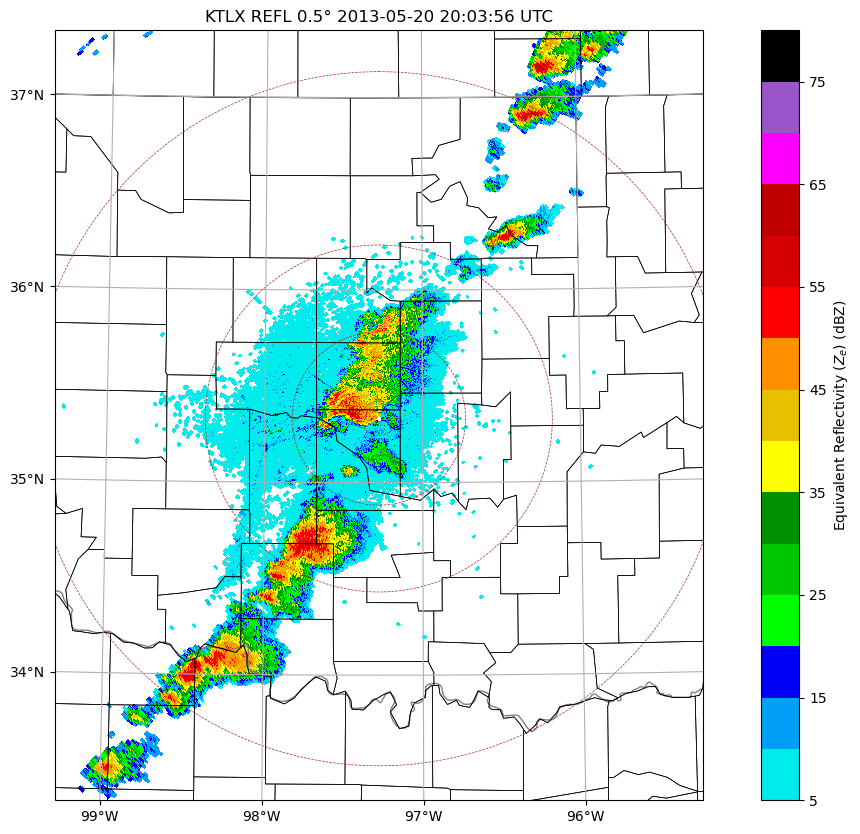

In [40]:
projLCC=ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
sweep = 0
# Call the function that creates the title string, among other things.
timeSweepStr, elevSweepStr = nexRadSweepTimeElev (radar, sweep)
titleStr = f'{site} {shortName} {elevSweepStr} {timeSweepStr}'

# Create our figure
fig = plt.figure(figsize=(15, 10))

# Set up a single axes and plot reflectivity
ax = fig.add_subplot(111, projection=projLCC)
ax.set_extent ([lonW, lonE, latS, latN])

display = pyart.graph.RadarMapDisplay(radar)
ref_map = display.plot_ppi_map(field,sweep=sweep, ax=ax, raster=False, title=titleStr,
            colorbar_label='Equivalent Reflectivity ($Z_{e}$) (dBZ)', norm=ref_norm, cmap=ref_cmap, resolution=res,projection=projLCC,min_lat=latS,max_lat=latN,
                              min_lon=lonW, max_lon=lonE)
range_rings = display.plot_range_rings([10,50,100,200],ax=ax, col='brown',ls='dashed',lw=0.5)

# Add counties
ax.add_feature(USCOUNTIES, linewidth=0.5);

## Create a [VAD wind profile](https://courses.comet.ucar.edu/pluginfile.php/3788/mod_imscp/content/1/velocity_azimuth_display.html)

In [42]:
# Loop on all sweeps and compute VAD
zlevels = np.arange(100, 5000, 100)  # height above radar
u_allsweeps = []
v_allsweeps = []

#Select only those sweeps that have velocity data
for idx in [1,3,5,6,7,8,10,11,12,13,14,15,16]:    #originally goes up to 18 but for some reason station does not go up to 18
    print (idx)
    radar_1sweep = radar.extract_sweeps([idx])
    vad = pyart.retrieve.vad_browning(
        radar_1sweep, "velocity", z_want=zlevels
    )
    u_allsweeps.append(vad.u_wind)
    v_allsweeps.append(vad.v_wind)

1
max height 6595.0  meters
min height 20.0  meters
3
max height 9671.0  meters
min height 34.0  meters
5
max height 10310.0  meters
min height 50.0  meters
6
max height 7992.0  meters
min height 75.0  meters
7
max height 9610.0  meters
min height 87.0  meters
8
max height 12048.0  meters
min height 114.0  meters
10
max height 12626.0  meters
min height 186.0  meters
11
max height 13539.0  meters
min height 235.0  meters
12
max height 14966.0  meters
min height 301.0  meters
13
max height 14063.0  meters
min height 372.0  meters
14
max height 13636.0  meters
min height 455.0  meters
15
max height 13681.0  meters
min height 580.0  meters
16
max height 13425.0  meters
min height 711.0  meters


Text(0.5, 0.98, 'Wind profile obtained from VAD')

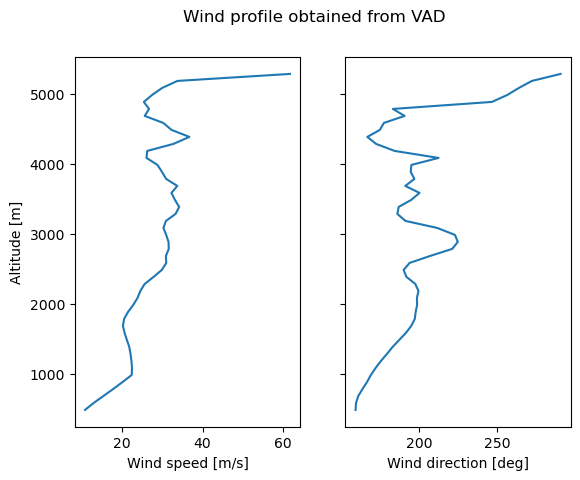

In [43]:
# Average U and V over all sweeps and compute magnitude and angle
u_avg = np.nanmean(np.array(u_allsweeps), axis=0)
v_avg = np.nanmean(np.array(v_allsweeps), axis=0)
orientation = np.rad2deg(np.arctan2(-u_avg, -v_avg)) % 360
speed = np.sqrt(u_avg**2 + v_avg**2)

# Display vertical profile of wind
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(speed * 2, zlevels + radar.altitude["data"])
ax[1].plot(orientation, zlevels + radar.altitude["data"])
ax[0].set_xlabel("Wind speed [m/s]")
ax[1].set_xlabel("Wind direction [deg]")
ax[0].set_ylabel("Altitude [m]")
fig.suptitle("Wind profile obtained from VAD")